# Hard skill test | Data Engineer

In [1]:
import json
import pandas as pd
import os
import re
from datetime import datetime
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Data, Transforming & Saving

In [2]:
equipmentspath = os.path.join('Data', 'equipment.json')
equipment_sensorspath = os.path.join('Data', 'equipment_sensors.csv')
equipment_failurepath = os.path.join('Data', 'equipment_failure_sensors.log')

equipment_sensors = pd.read_csv(equipment_sensorspath, sep = ";")

# All the files will be saved in SQL Database

with open(equipmentspath, 'r') as file:
    equipments = json.load(file)
    
database_filename = os.path.join(os.getcwd(), "Data", "ShapeDigital_DataEngineer.db")

if os.path.exists(database_filename):
    os.remove(database_filename)
    
engine = create_engine('sqlite:///' + database_filename)


# The log file has a lot of lines and can take a while to write all the lines, so i have added a "chunk" to be written after some lines.

chunk = 1000
data = []
i = 0
with open(equipment_failurepath) as file:
    for line in file:
        if len(line) > 0:
            line = line.split(sep='\t')
            datetime = datetime.strptime(line[0], '[%Y-%m-%d %H:%M:%S]')
            category = line[1]
            sensor = int(re.findall(r'\d+', line[2])[0])
            temperature = float(re.findall(r'[-]*\d*\.*\d*', line[4])[0])
            vibration = float(re.findall(r'[-]*\d*\.*\d*', line[5])[0])
            line = {'Date': datetime, 
                    'Category': category, 
                    'sensor_id': sensor, 
                    'Temperature': temperature, 
                    'Vibration': vibration}
            if len(data) == chunk:
                i+=1
                pd.DataFrame(data).to_sql('Equipment_Failure', engine, index=False, if_exists='append')
                data = []
            else:
                data.append(line)
    if len(data) > 0:
        i+=1
        pd.DataFrame(data).to_sql('Equipment_Failure', engine, index=False, if_exists='append')
        data = []
print("The {} blocks have been written".format(i))      
          

The 37 blocks have been written


In [3]:
equipment_sensors.to_sql('Equipment_Sensor', engine, index=False, if_exists='replace')

100

In [4]:
pd.DataFrame(equipments).to_sql('Equipments', engine, index=False, if_exists='replace')

14

## Data Undestanding

In [5]:
sql = "SELECT Date, Category, Equipment_Failure.sensor_id, Temperature, Vibration, Equipment_Sensor.equipment_id, code, group_name FROM Equipment_Failure\
        LEFT JOIN Equipment_Sensor ON Equipment_Failure.sensor_id=Equipment_Sensor.sensor_id\
        LEFT JOIN Equipments ON Equipment_Sensor.equipment_id=Equipments.equipment_id\
        WHERE Date BETWEEN '2020-01-01' AND '2020-02-01'"

ef = pd.read_sql_query(sql, engine).sort_values(by='Date')

In [6]:
ef.head(15)

,Date,Category,sensor_id,Temperature,Vibration,equipment_id,code,group_name
8431,2020-01-01 00:53:32.000000,ERROR,24,128.13,-7866.01,12,CF304D24,FGHQWR2Q
8433,2020-01-01 00:53:32.000000,ERROR,35,234.02,-7366.61,12,CF304D24,FGHQWR2Q
8434,2020-01-01 00:53:32.000000,ERROR,55,492.43,-8248.63,12,CF304D24,FGHQWR2Q
8435,2020-01-01 00:53:32.000000,ERROR,63,56.50,5289.27,12,CF304D24,FGHQWR2Q
8436,2020-01-01 00:53:32.000000,ERROR,70,486.98,9294.85,12,CF304D24,FGHQWR2Q
8437,2020-01-01 00:53:32.000000,ERROR,72,332.98,-8948.68,12,CF304D24,FGHQWR2Q
8438,2020-01-01 00:53:32.000000,ERROR,82,192.56,-5963.73,12,CF304D24,FGHQWR2Q
8439,2020-01-01 00:53:32.000000,ERROR,96,415.69,7104.55,12,CF304D24,FGHQWR2Q
8432,2020-01-01 00:53:32.000000,ERROR,33,342.76,6483.49,12,CF304D24,FGHQWR2Q
9936,2020-01-01 01:04:27.000000,ERROR,79,338.83,8605.29,2,43B81579,VAPQY59S


In [7]:
ef.describe()

,sensor_id,Temperature,Vibration,equipment_id
count,11635.000000,11635.000000,11635.000000,11635.000000
mean,49.596132,249.511580,34.085668,7.154276
std,28.417440,144.487527,5759.687814,3.775550
min,1.000000,0.090000,-9999.980000,1.000000
25%,25.000000,124.560000,-4948.830000,4.000000
50%,49.000000,250.840000,31.380000,7.000000
75%,74.000000,374.075000,4971.815000,11.000000
max,100.000000,499.920000,9999.970000,13.000000


The Vibrations and Temperatures have an upper limit of 10000 and 500, respectively, which could indicate out-of-range readings in the Sensors.

In [8]:
ef[['Category', 'code', 'group_name']].nunique()

Category       1
code          13
group_name     6
dtype: int64

Above  there are the number of categories.

In [9]:
ef.groupby(by=['group_name', 'code']).count().iloc[:,0].rename('Quantity')

group_name  code    
9N127Z5P    78FFAD0C     990
            ADE40E7F     742
FGHQWR2Q    5310B9D7     528
            CF304D24     999
            E1AD07D4    1376
            E54B5C3A     719
NQWPA8D3    86083278     927
            98B84035     819
PA92NCXZ    09C37FB8     811
            9AD15F7E     903
VAPQY59S    3329175B     760
            43B81579     903
Z9K1SAP4    4E834E81    1158
Name: Quantity, dtype: int64

### 1 – Total equipment failures that happened?

In [10]:
totalfails = ef.groupby(by='Category').count().iloc[:,0].rename('Quantity').values
totalfails

array([11635])

In [11]:
print(f"The total equipment failures in January was {totalfails[0]}.")

The total equipment failures in January was 11635.


### 2 – Which equipment code had most failures?

In [12]:
eq_fails = ef.groupby(by=['group_name', 'code']).count().iloc[:,0].rename('Quantity of failures').sort_values(ascending = False)
eq_fails

group_name  code    
FGHQWR2Q    E1AD07D4    1376
Z9K1SAP4    4E834E81    1158
FGHQWR2Q    CF304D24     999
9N127Z5P    78FFAD0C     990
NQWPA8D3    86083278     927
PA92NCXZ    9AD15F7E     903
VAPQY59S    43B81579     903
NQWPA8D3    98B84035     819
PA92NCXZ    09C37FB8     811
VAPQY59S    3329175B     760
9N127Z5P    ADE40E7F     742
FGHQWR2Q    E54B5C3A     719
            5310B9D7     528
Name: Quantity of failures, dtype: int64

In [13]:
print(f"The Equipment {eq_fails.index[0][1]} from the group {eq_fails.index[0][0]} had {eq_fails[0]} fails.")

The Equipment E1AD07D4 from the group FGHQWR2Q had 1376 fails.


### 3 – Average amount of failures across equipment group, ordered by the number of failures in ascending order?

In [14]:
eq_fails.reset_index().groupby(by='group_name').mean().sort_values(by = 'Quantity of failures', ascending=True)

,Quantity of failures
group_name,
VAPQY59S,831.5
PA92NCXZ,857.0
9N127Z5P,866.0
NQWPA8D3,873.0
FGHQWR2Q,905.5
Z9K1SAP4,1158.0


Attention: Besides the group, **Z9K1SAP4** has the most failures on average it has the second equipment with the most failures, and the group **FGHQWR2Q** has the equipment with the most failures. So, an evaluation via weighted "production volume" could be a better option to rank the groups.

### Extras Evaluations

#### 4 - Does the Temperature or Vibration have a range where most failures occur? 

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

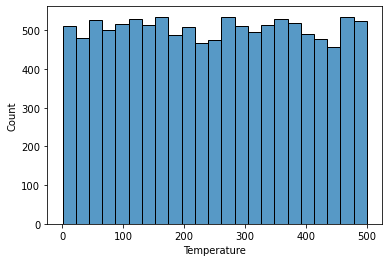

In [15]:
sns.histplot(data=ef, x="Temperature")

<AxesSubplot:xlabel='Vibration', ylabel='Count'>

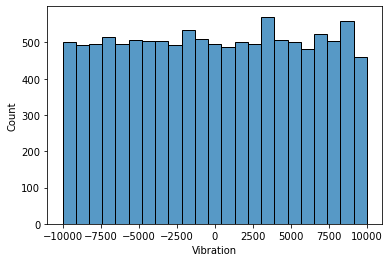

In [16]:
sns.histplot(data=ef, x="Vibration")

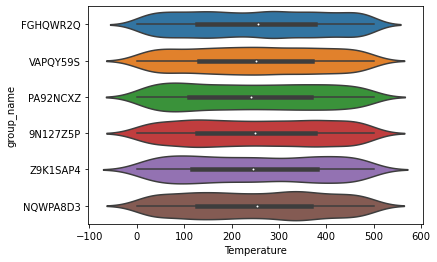

In [17]:
ax = sns.violinplot(x=ef["Temperature"], y=ef['group_name'])

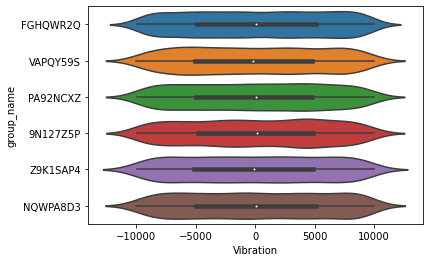

In [18]:
ax = sns.violinplot(x=ef["Vibration"], y=ef['group_name'])

In [19]:
bins = 20
ef['Temperature_bins'] = pd.cut(ef['Temperature'],bins=bins)
ef['Vibration_bins'] = pd.cut(ef['Vibration'], bins=bins)

In [20]:
ef

,Date,Category,sensor_id,Temperature,Vibration,equipment_id,code,group_name,Temperature_bins,Vibration_bins
8431,2020-01-01 00:53:32.000000,ERROR,24,128.13,-7866.01,12,CF304D24,FGHQWR2Q,"(125.048, 150.039]","(-7999.985, -6999.988]"
8433,2020-01-01 00:53:32.000000,ERROR,35,234.02,-7366.61,12,CF304D24,FGHQWR2Q,"(225.014, 250.005]","(-7999.985, -6999.988]"
8434,2020-01-01 00:53:32.000000,ERROR,55,492.43,-8248.63,12,CF304D24,FGHQWR2Q,"(474.929, 499.92]","(-8999.982, -7999.985]"
8435,2020-01-01 00:53:32.000000,ERROR,63,56.50,5289.27,12,CF304D24,FGHQWR2Q,"(50.073, 75.065]","(4999.982, 5999.98]"
8436,2020-01-01 00:53:32.000000,ERROR,70,486.98,9294.85,12,CF304D24,FGHQWR2Q,"(474.929, 499.92]","(8999.972, 9999.97]"
...,...,...,...,...,...,...,...,...,...,...
3902,2020-01-31 22:41:53.000000,ERROR,87,49.28,-3721.88,7,E54B5C3A,FGHQWR2Q,"(25.082, 50.073]","(-3999.995, -2999.998]"
3903,2020-01-31 22:41:53.000000,ERROR,88,391.10,2157.63,7,E54B5C3A,FGHQWR2Q,"(374.963, 399.954]","(1999.99, 2999.987]"
3904,2020-01-31 22:41:53.000000,ERROR,93,139.75,-271.32,7,E54B5C3A,FGHQWR2Q,"(125.048, 150.039]","(-1000.003, -0.005]"
3899,2020-01-31 22:41:53.000000,ERROR,8,62.92,-7275.96,7,E54B5C3A,FGHQWR2Q,"(50.073, 75.065]","(-7999.985, -6999.988]"


In [21]:
heatdf = ef.groupby(by=['Temperature_bins', 'Vibration_bins']).count().iloc[:, 0].reset_index()
heatdf = heatdf.rename(columns={'Date':'Quantity'})

In [22]:
heatdf

,Temperature_bins,Vibration_bins,Quantity
0,"(-0.41, 25.082]","(-10019.98, -8999.982]",23
1,"(-0.41, 25.082]","(-8999.982, -7999.985]",29
2,"(-0.41, 25.082]","(-7999.985, -6999.988]",27
3,"(-0.41, 25.082]","(-6999.988, -5999.99]",29
4,"(-0.41, 25.082]","(-5999.99, -4999.992]",16
...,...,...,...
395,"(474.929, 499.92]","(4999.982, 5999.98]",22
396,"(474.929, 499.92]","(5999.98, 6999.977]",32
397,"(474.929, 499.92]","(6999.977, 7999.975]",32
398,"(474.929, 499.92]","(7999.975, 8999.972]",31


In [23]:
heatdf = pd.pivot_table(heatdf, values='Quantity', index=['Temperature_bins'], columns=['Vibration_bins'])

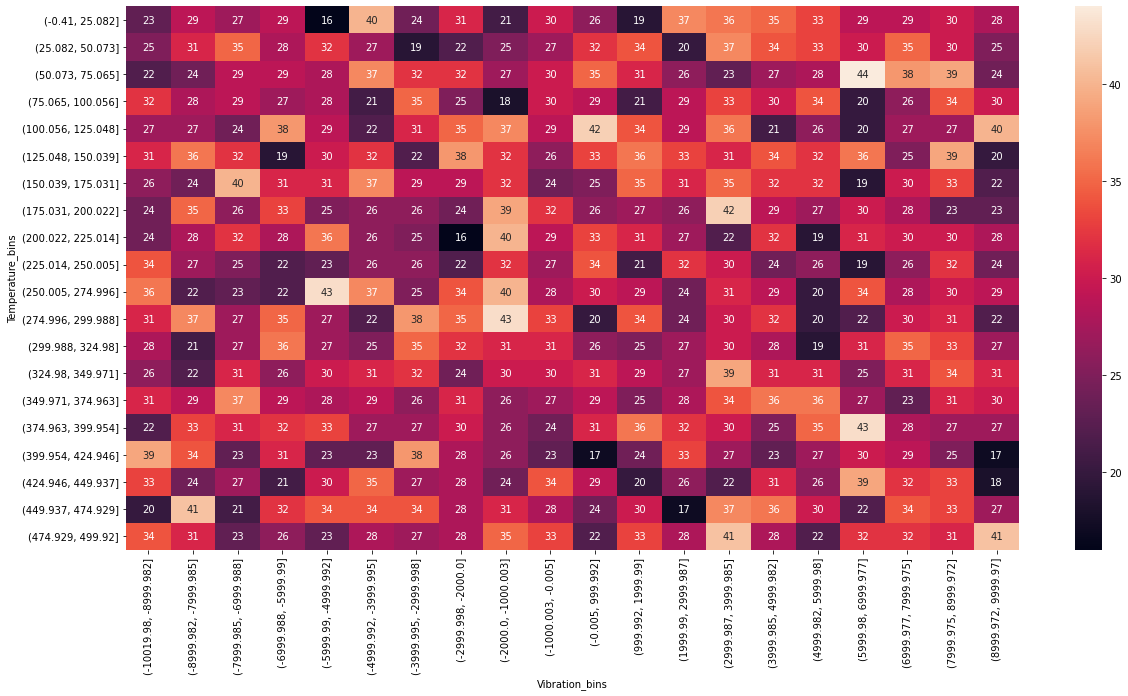

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(heatdf, annot=True)

Besides, few combinations of temperatures and Vibrations have more Errors. The first analysis indicates an irrelevant correlation.

#### 5 - Any concentration of error in a specific time zone?

##### 5.1 - Weekday X Hours

In [25]:
ef['Date'] = ef['Date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [26]:
ef['Hour'] = ef['Date'].apply(lambda x: x.hour)

In [27]:
ef['weekday'] = ef['Date'].apply(lambda x : x.weekday())

In [28]:
ef

,Date,Category,sensor_id,Temperature,Vibration,equipment_id,code,group_name,Temperature_bins,Vibration_bins,Hour,weekday
8431,2020-01-01 00:53:32,ERROR,24,128.13,-7866.01,12,CF304D24,FGHQWR2Q,"(125.048, 150.039]","(-7999.985, -6999.988]",0,2
8433,2020-01-01 00:53:32,ERROR,35,234.02,-7366.61,12,CF304D24,FGHQWR2Q,"(225.014, 250.005]","(-7999.985, -6999.988]",0,2
8434,2020-01-01 00:53:32,ERROR,55,492.43,-8248.63,12,CF304D24,FGHQWR2Q,"(474.929, 499.92]","(-8999.982, -7999.985]",0,2
8435,2020-01-01 00:53:32,ERROR,63,56.50,5289.27,12,CF304D24,FGHQWR2Q,"(50.073, 75.065]","(4999.982, 5999.98]",0,2
8436,2020-01-01 00:53:32,ERROR,70,486.98,9294.85,12,CF304D24,FGHQWR2Q,"(474.929, 499.92]","(8999.972, 9999.97]",0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3902,2020-01-31 22:41:53,ERROR,87,49.28,-3721.88,7,E54B5C3A,FGHQWR2Q,"(25.082, 50.073]","(-3999.995, -2999.998]",22,4
3903,2020-01-31 22:41:53,ERROR,88,391.10,2157.63,7,E54B5C3A,FGHQWR2Q,"(374.963, 399.954]","(1999.99, 2999.987]",22,4
3904,2020-01-31 22:41:53,ERROR,93,139.75,-271.32,7,E54B5C3A,FGHQWR2Q,"(125.048, 150.039]","(-1000.003, -0.005]",22,4
3899,2020-01-31 22:41:53,ERROR,8,62.92,-7275.96,7,E54B5C3A,FGHQWR2Q,"(50.073, 75.065]","(-7999.985, -6999.988]",22,4


In [29]:
heatdf = ef.groupby(by=['weekday', 'Hour']).count().iloc[:,0].reset_index()

In [30]:
heatdf = heatdf.rename(columns={'Date':'Quantity'})

In [31]:
heatdf = pd.pivot_table(heatdf, values='Quantity', index=['weekday'], columns=['Hour'])

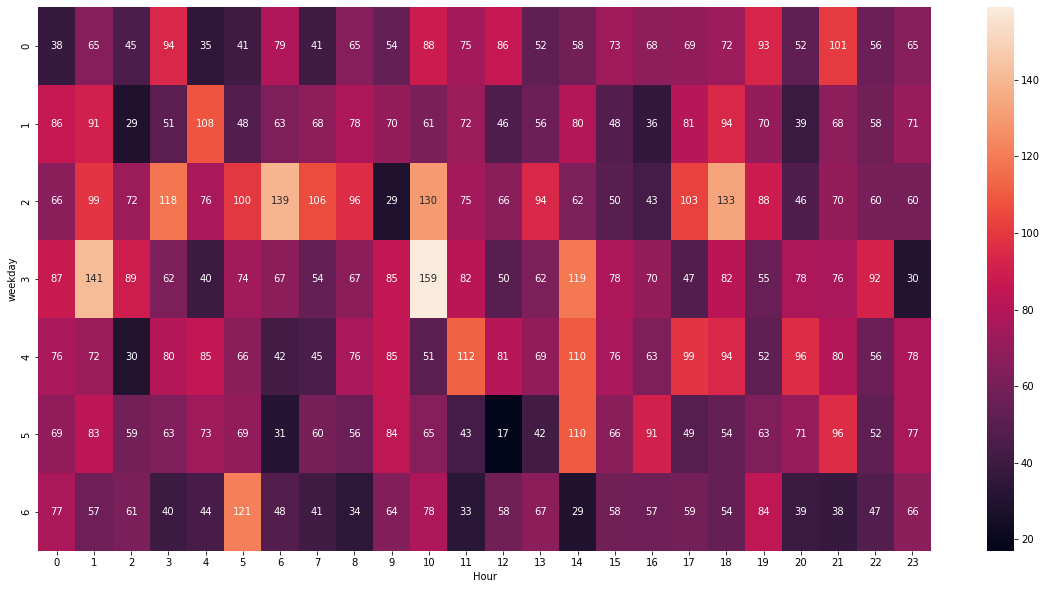

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(heatdf, annot=True, fmt='g')

There is some concentration of Errors on Wednesday(weekday 2) in the Morning. It is indicative that some problems can be correlated to specific dates and times. 

##### 5.2 - Days X Hours

In [33]:
ef['Day'] = ef['Date'].apply(lambda x: x.day)

In [34]:
heatdf = ef.groupby(by=['Day', 'Hour']).count().iloc[:,0].reset_index()
heatdf = heatdf.rename(columns={'Date':'Quantity'})

In [35]:
heatdf = pd.pivot_table(heatdf, values='Quantity', index=['Hour'], columns=['Day'])

In [36]:
heatdf = heatdf.fillna(0)

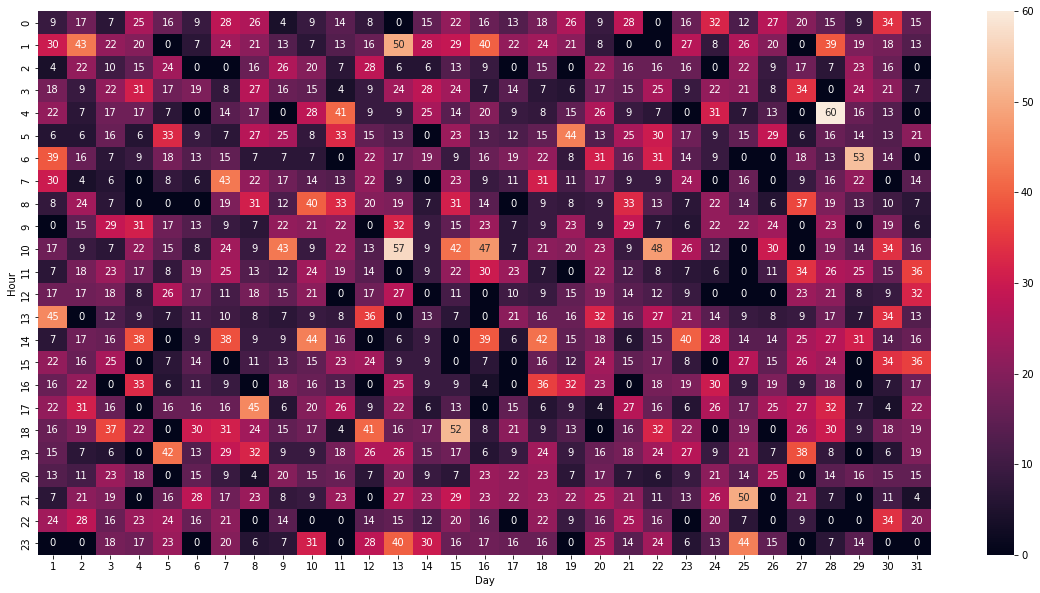

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(heatdf, annot=True, fmt='g')

It seems the errors don't occur in the same Time frame. Occurring a lot of isolated cases.